1. Loading Libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2. Loading Dataset

In [2]:
df = pd.read_csv("emissions.csv")
df.head()

,year,state-name,sector-name,fuel-name,value
0,1970,Alabama,Industrial carbon dioxide emissions,Coal,26.721507
1,1970,Alabama,Industrial carbon dioxide emissions,Petroleum,3.577779
2,1970,Alabama,Industrial carbon dioxide emissions,Natural Gas,8.944097
3,1970,Alabama,Industrial carbon dioxide emissions,All Fuels,39.243383
4,1970,Alabama,Total carbon dioxide emissions from all sectors,All Fuels,102.646851


3. Data Wrangling

In [3]:
df.isnull().sum()

year           0
state-name     0
sector-name    0
fuel-name      0
value          0
dtype: int64

In [4]:
# Checking  outliers in the "value" column using interquartile range (IQR)
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)]
cleaned_data = df[(df['value'] >= lower_bound) & (df['value'] <= upper_bound)]

# convert "year" to datetime format
cleaned_data['year'] = pd.to_datetime(cleaned_data['year'], format='%Y')

# Verify the cleaned dataset
cleaned_data.info(), cleaned_data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 52517 entries, 0 to 59900
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   year         52517 non-null  datetime64[ns]
 1   state-name   52517 non-null  object        
 2   sector-name  52517 non-null  object        
 3   fuel-name    52517 non-null  object        
 4   value        52517 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 2.4+ MB


C:\Users\Hassan Laptop Point\AppData\Local\Temp\ipykernel_480\169838445.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['year'] = pd.to_datetime(cleaned_data['year'], format='%Y')


(None,
                                 year         value
 count                          52517  52517.000000
 mean   1994-11-30 23:12:32.190719232      8.019031
 min              1970-01-01 00:00:00      0.000022
 25%              1982-01-01 00:00:00      0.603549
 50%              1995-01-01 00:00:00      2.978611
 75%              2008-01-01 00:00:00     11.262214
 max              2021-01-01 00:00:00     47.336662
 std                              NaN     10.872341)

4. EDA

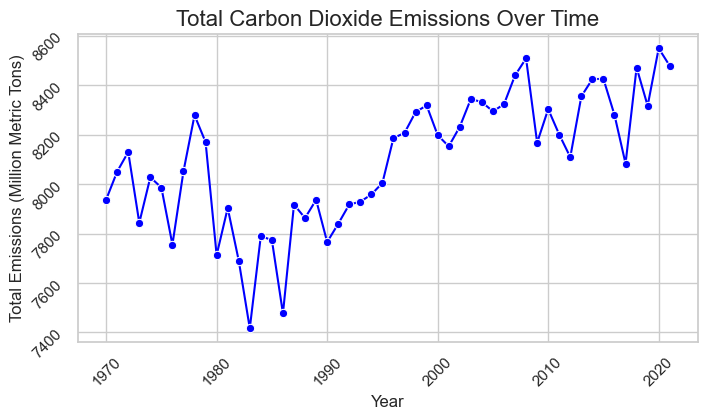

In [5]:
sns.set(style="whitegrid")
# 1. Total emissions trend over time
total_emissions = cleaned_data.groupby('year')['value'].sum()
plt.figure(figsize=(8, 4))
sns.lineplot(x=total_emissions.index, y=total_emissions.values, marker='o', color='blue')
plt.title("Total Carbon Dioxide Emissions Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Emissions (Million Metric Tons)", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()


C:\Users\Hassan Laptop Point\AppData\Local\Temp\ipykernel_480\1453847325.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_states.index, y=top_states.values, palette='viridis')


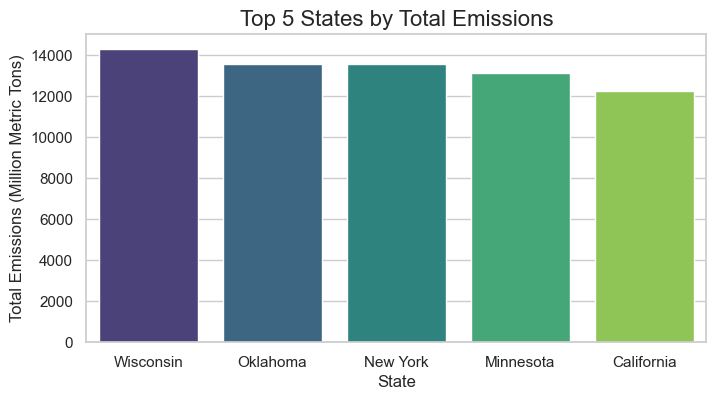

In [6]:
# Top 5 states with highest total emissions
top_states = cleaned_data.groupby('state-name')['value'].sum().sort_values(ascending=False).head(5)
plt.figure(figsize=(8, 4))
sns.barplot(x=top_states.index, y=top_states.values, palette='viridis')
plt.title("Top 5 States by Total Emissions", fontsize=16)
plt.xlabel("State", fontsize=12)
plt.ylabel("Total Emissions (Million Metric Tons)", fontsize=12)
plt.show()

C:\Users\Hassan Laptop Point\AppData\Local\Temp\ipykernel_480\2176362685.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_sector.index, y=state_sector.values, palette='magma')


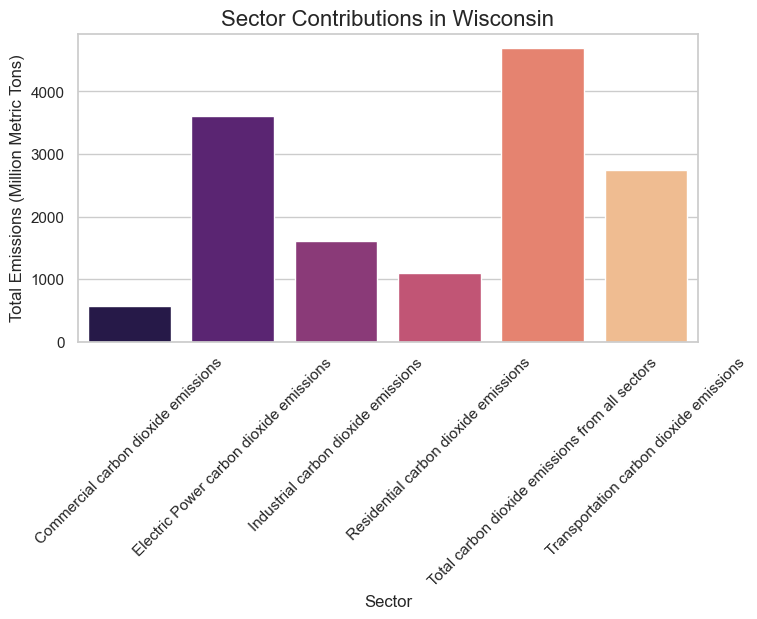

In [7]:
# Sector contributions for the top-emitting state
top_state = top_states.index[0]
state_sector = cleaned_data[cleaned_data['state-name'] == top_state].groupby('sector-name')['value'].sum()
plt.figure(figsize=(8, 4))
sns.barplot(x=state_sector.index, y=state_sector.values, palette='magma')
plt.title(f"Sector Contributions in {top_state}", fontsize=16)
plt.xlabel("Sector", fontsize=12)
plt.ylabel("Total Emissions (Million Metric Tons)", fontsize=12)
plt.xticks(rotation=45)
plt.show()

C:\Users\Hassan Laptop Point\AppData\Local\Temp\ipykernel_480\2467999584.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fuel_contributions.index, y=fuel_contributions.values, palette='coolwarm')


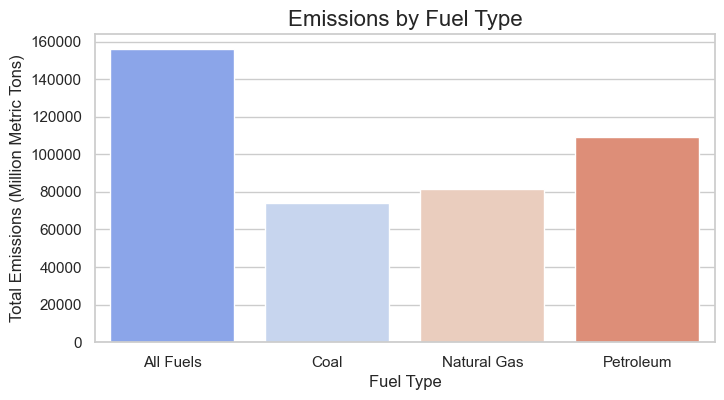

In [8]:
# Fuel type contributions across all states
fuel_contributions = cleaned_data.groupby('fuel-name')['value'].sum()
plt.figure(figsize=(8, 4))
sns.barplot(x=fuel_contributions.index, y=fuel_contributions.values, palette='coolwarm')
plt.title("Emissions by Fuel Type", fontsize=16)
plt.xlabel("Fuel Type", fontsize=12)
plt.ylabel("Total Emissions (Million Metric Tons)", fontsize=12)
plt.show()

5. Predictive Model

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Encode categorical variables using one-hot encoding
encoded_data = pd.get_dummies(cleaned_data, columns=['state-name', 'sector-name', 'fuel-name'], drop_first=True)

# Features (X) and target (y)
X = encoded_data.drop(['value', 'year'], axis=1)
y = encoded_data['value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse, mae, r2


c:\Users\Hassan Laptop Point\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(3.5861907773339503),
 np.float64(1.8094645662170343),
 0.8902881205348132)